In [2]:
import pandas as pd
import numpy as np

In [3]:
#50
index='ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP'.split(" \t ")

df = pd.read_csv("../data/NewsAggregatorDataset/newsCorpora.csv", names=index,  sep="\t")

df=df[df.PUBLISHER.isin(["Reuters", "Huffington Post", "Businessweek", "Contactmusic.com", "Daily Mail"])].sample(frac=1)

df.iloc[:int(len(df)*0.8)].to_csv("../data/train.txt", sep="\t", index=False)
df.iloc[int(len(df)*0.8):int(len(df)*0.9)].to_csv("../data/valid.txt", sep="\t", index=False)
df.iloc[int(len(df)*0.9):].to_csv("../data/test.txt", sep="\t", index=False)

In [99]:
df.CATEGORY.unique()

array(['e', 'b', 't', 'm'], dtype=object)

In [4]:
train = pd.read_csv("../data/train.txt", sep="\t")
print(len(train))
valid = pd.read_csv("../data/valid.txt", sep='\t')
print(len(valid))
test = pd.read_csv("../data/test.txt", sep="\t")
print(len(test))

10672
1334
1334


In [8]:
#51
def add_words(df):
    df["words"] = df.TITLE.apply(lambda x: x.split(" "))
    return df
def get_vec(df):
    result=[]
    for sentence in df.words.values:
        sentence_vec=[0]*len(vec)
        for word in sentence:
            if word in vec:
                sentence_vec[vec.index(word)]=1
        result.append(sentence_vec)
    return result

train = add_words(train)
valid = add_words(valid)
test = add_words(test)

from collections import defaultdict
frequency = defaultdict(int)
for text in train.words:
    for token in text:
        frequency[token] += 1
vec=[]
for k, v in frequency.items():
    if v>=5:
        vec.append(k)

np.savetxt("../data/train.feature.txt", np.array(get_vec(train)))
np.savetxt("../data/valid.feature.txt", np.array(get_vec(valid)))
np.savetxt("../data/test.feature.txt", np.array(get_vec(test)))

In [21]:
#52
X_train = np.loadtxt('../data/train.feature.txt')
X_valid = np.loadtxt('../data/valid.feature.txt')
X_test = np.loadtxt('../data/test.feature.txt')

In [72]:
y_train = train.CATEGORY.values
y_valid = valid.CATEGORY.values
y_test = test.CATEGORY.values

In [59]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression().fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [89]:
#53
def get_label_proba(model, X):
    label = model.predict(X)
    proba = model.predict_proba(X)
    return label, proba

In [90]:
#54
def accuracy(y_hat, y):
    cnt = 0
    for i in range(len(y_hat)):
        if y_hat[i]==y[i]:
            cnt+=1
    return cnt/len(y_hat)
train_hat, _ = get_label_proba(clf, X_train)
valid_hat, _ = get_label_proba(clf, X_valid)
test_hat, _ = get_label_proba(clf, X_test)
print("train acc:", accuracy(train_hat, y_train))
print("valid acc:", accuracy(valid_hat, y_valid))

train acc: 0.9491191904047976
valid acc: 0.8733133433283359


In [94]:
#55
from sklearn.metrics import confusion_matrix
train_cmatrix=confusion_matrix(y_train,train_hat, labels=['e', 'b', 't', 'm'])
print(train_cmatrix)

[[4388   60    4   44]
 [  43 4190    3    4]
 [  72   70  570    8]
 [ 153   76    6  981]]


In [105]:
#56
for i , label in enumerate(['e', 'b', 't', 'm']):
    recall = train_cmatrix[i][i]/np.sum(train_cmatrix[i,:])
    precision = train_cmatrix[i][i]/np.sum(train_cmatrix[:,i])
    print(label)
    print("再現性", recall)
    print("適合性", precision)
    print("F1", 2/ ((1/recall)+(1/precision)))
    print("---------------------------------")

e
再現性 0.9759786476868327
適合性 0.9424398625429553
F1 0.9589160839160839
---------------------------------
b
再現性 0.9882075471698113
適合性 0.9531392174704276
F1 0.970356646595646
---------------------------------
t
再現性 0.7916666666666666
適合性 0.9777015437392796
F1 0.8749040675364544
---------------------------------
m
再現性 0.8067434210526315
適合性 0.9459980713596914
F1 0.8708388814913449
---------------------------------


In [123]:
#57
worst10=np.argsort(abs(clf.coef_).sum(axis=0))[:10]
print("worst10 words: ",[vec[num] for num in worst10])
top10=np.argsort(abs(clf.coef_).sum(axis=0))[-10:]
print("top10  words: ",[vec[num] for num in top10])

worst10 words:  ['anxiety', 'least', 'Mccartney', 'announce', 'married', 'toned', 'Katt', 'MARKETS-Wall', 'where', 'Pride']
top10  words:  ['FCC', 'Apple', 'Climate', 'Microsoft', 'MERS', 'Bank', 'FDA', 'Google', 'Ebola', 'Facebook']


In [136]:
#58
train_acc=[]
valid_acc=[]
for i in range(1,11):
    clf = LogisticRegression(C=i*0.1).fit(X_train, y_train)
    train_hat, _ = get_label_proba(clf, X_train)
    valid_hat, _ = get_label_proba(clf, X_valid)
    train_acc.append(accuracy(train_hat, y_train))
    valid_acc.append(accuracy(valid_hat, y_valid))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

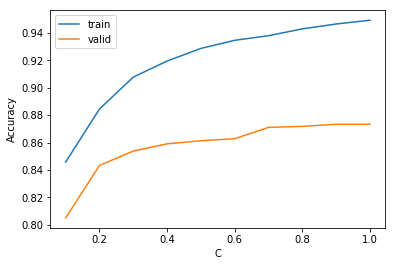

In [137]:
import matplotlib.pyplot as plt
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot([i*0.1 for i in range(1,11)], train_acc, label="train")
plt.plot([i*0.1 for i in range(1,11)], valid_acc, label="valid")
plt.legend()
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed

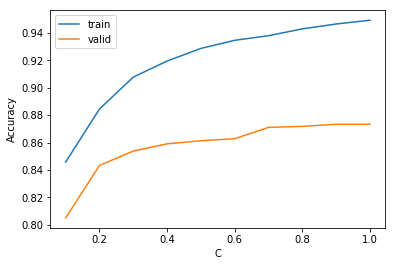

In [150]:
#59
train_acc=[]
valid_acc=[]
for i in range(1,11):
    clf = LogisticRegression(C=0.1*i).fit(X_train, y_train)
    train_hat, _ = get_label_proba(clf, X_train)
    valid_hat, _ = get_label_proba(clf, X_valid)
    train_acc.append(accuracy(train_hat, y_train))
    valid_acc.append(accuracy(valid_hat, y_valid))
import matplotlib.pyplot as plt
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot([i*0.1 for i in range(1,11)], train_acc, label="train")
plt.plot([i*0.1 for i in range(1,11)], valid_acc, label="valid")
plt.legend()
plt.show()

In [139]:
used_model = LogisticRegression(C=np.argmax(valid_acc)).fit(X_train, y_train)
test_hat, _ = get_label_proba(used_model, X_test)
print(accuracy(v_hat, y_test))

[0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976,
 0.9491191904047976]